# Day 1 Notebook

#Initial Setup of Python Environment
Over the course of the next few days, we will rely on a number of python modules. Google Colaboratory comes equipped with a large number of these modules, but there are a few that we need that are not provided by default. Run the cells below to install these modules. You can optionally comment out modules that are only necessary for specific days that you will not be attending.

In [2]:
# Get non-default modules
!pip install rdkit-pypi
'''
!apt-get -qq install -y graphviz && pip install -q pydot
!pip install jaxlib jax
!pip install leruli # only necessary for day 3
'''

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 4.3 MB/s 


'\n!apt-get -qq install -y graphviz && pip install -q pydot\n!pip install jaxlib jax\n!pip install leruli # only necessary for day 3\n'

# Activity 0: Coneptualization with Linear Regression
Many of the important concepts in supervised machine learning can be appreciated by a solid understanding of linear regression, which we all probably encountered early on -- like elementary school. We are going to work through a linear regression task in a fashion  to appreciate many of the basic mechanics that underlie deep learning. 

To start, we will pull a dataset generated in a recent paper that explores the use of machine learning to predict polymer properties. The label  that we extract (and our target for prediction) will be the radius of gyration ($R_g$), which provides a measure of an object's size, for some simulated intrinsically disordered proteins. 

A well known result from polymer physics is that $R_g \propto M^{0.5}$, where $M$ is the number of some statistically uncorrelated sub-units in the polymer; the same result arises in the context of diffusion/random walks. 

In the following, we will examine how well the data on $R_g$ can be described by a simple linear model with $N^{0.5}$ as our input feature ($N$ will be the number of residues in the protein, which we do not generally expect to be a statistically uncorrelated sub-unit)

Run the cell below to obtain and view the data. 

In [15]:
# modules for this activity
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics     import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection  import train_test_split, KFold

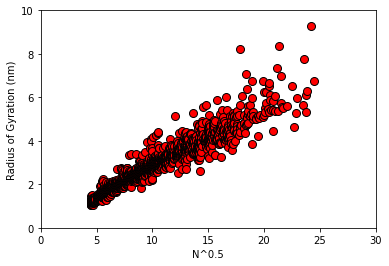

In [1]:
def plot_raw_data(x,y):
  plt.plot(x, y,marker='o',linestyle="",markersize=8,color='r',markeredgecolor='k')
  plt.ylabel("Radius of Gyration (nm)")
  plt.xlabel("N^0.5")
  plt.xlim(0,30)
  plt.ylim(0,10)
  return plt.gca()

url_for_labels    = "https://raw.githubusercontent.com/webbtheosim/featurization/main/Dataset_A/labels.csv"
url_for_sequences = "https://raw.githubusercontent.com/webbtheosim/featurization/main/Dataset_A/sequences.txt"
idpdata = pd.read_csv(
    url_for_labels
)
idpdata.head()
y = idpdata['ROG (A)'].to_numpy()/10.     # these are now labels

import urllib.request
import random

seqs  = [line.strip().split() for line in urllib.request.urlopen(url_for_sequences)]
X     = np.array([len(seq) for seq in seqs])**0.5   # these are features

ax = plot_raw_data(X,y)

# Examining a human hypothesis 
At first glance, it certainly seems that there is reasonable linear correlation between our input and labels. 

We are going to consider a function of the form

$$R_g = \theta_0 + \theta_1 N^{0.5}$$

Can you look at the plot to "guess" values of these parameters? Complete the cell below and explore some "hypotheses".

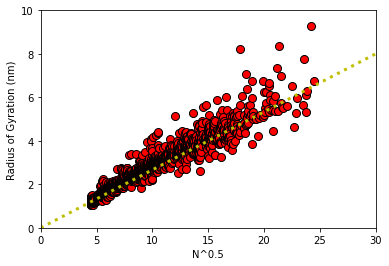

r2 = 0.930, MSE = 0.088, MAE = 0.162


In [5]:
# basic set up
Nmax = 900
xline= np.array(range(Nmax+1))**0.5
f    = lambda x, th: th[0] + th[1]*x

# fill in parameters
thetas = np.array([[0,8./30]]).T # this maps to a 2x1

# make predictions using function
yline = f(xline,thetas)

# examine hypothesis
ax = plot_raw_data(X,y)
ax.plot(xline,yline,color='y',linewidth=3,linestyle=':')
plt.show()

# make predictions from features and compute evaluation metrics
yhat  = f(X,thetas)
r2    = r2_score(y,yhat)
rmse  = mean_squared_error(y,yhat)
mae   = mean_absolute_error(y,yhat)
print("r2 = {:>5.3f}, MSE = {:>5.3f}, MAE = {:>5.3f}"\
      .format(r2,rmse,mae))

# Approach by more formal optimization
Probably your human-intuited fit yields a pretty darn good description of the data, but we'll try to do better.

The ``training'' of neural networks is really about *optimization* where the objective is to minimze a *loss* function that describes a disparity between the model predictions and the ground truth of some set of labels.

When we first encounter linear regression, our optimization is usually in the `least-squares' sense; that is, our loss function is the mean-squared error over our observations. The problem of linear least-squares regression can be ``exactly'' solved using techniques from linear algebra, but that is not so much the domain of machine learning. Therefore, we will approach a solution using gradient descent optimization, which is more akin to what is needed fro training a neural network.

Below we define and examine our loss function (a mean-squared error) over our parameter space (considering the whole dataset). We also place a star at the position of the hypothesis that we generated in the previous cell. Is it close to the minimum?

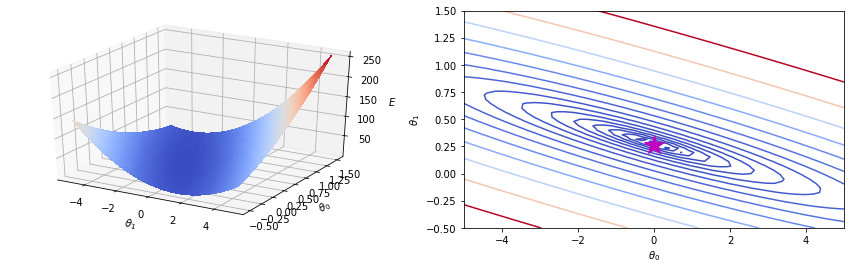

In [6]:
def loss(x,y,theta):
  ''' Function to calculate cost function assuming a hypothesis of form y^ = X*theta
  Inputs:
  x = array of dependent variable
  y = array of training examples
  theta = array of parameters for hypothesis

  Returns:
  E = cost function
  '''
  n        = len(y) #number of training examples
  features = np.ones((n,len(theta))) # X 
  features[:,1] = x[:]
  ypred = features@theta # predictions with current hypothesis
  E = np.sum((ypred[:,0]-y[:])**2)/n #Cost function
  return E

def plot_loss(t0,t1,E):
  t0g,t1g = np.meshgrid(t0,t1)
  fig = plt.figure(figsize=(15,4))
  ax1  = fig.add_subplot(1,2,1,projection='3d')
  surf = ax1.plot_surface(t0g, t1g, E, linewidth=0, antialiased=False,cmap='coolwarm')
  ax1.set_xlabel(r"$\theta_1$")
  ax1.set_ylabel(r"$\theta_0$")
  ax1.set_zlabel(r"$E$")
  ax2 = fig.add_subplot(1,2,2)
  CS = ax2.contour(t0g,t1g,E.T,np.logspace(-3,2,25),cmap='coolwarm')
  ax2.set_xlabel(r"$\theta_0$")
  ax2.set_ylabel(r"$\theta_1$") 

  return fig,ax1,ax2

#Define grid over which to calculate J
N = 50
theta0Rng = [-5,5]
theta1Rng = [-0.5,1.5]
theta0s = np.linspace(theta0Rng[0],theta0Rng[1],N)
theta1s = np.linspace(theta1Rng[0],theta1Rng[1],N)

#Initialize E as a matrix to store cost function values
E = np.zeros((N,N))

# Populate matrix
for i,theta0 in enumerate(theta0s):
  for j,theta1 in enumerate(theta1s):
    theta_ij = np.array([[theta0,theta1]]).T
    E[i,j]   = loss(X,y,theta_ij)

fig,ax1,ax2 = plot_loss(theta0s,theta1s,E)
ax2.plot(thetas[0],thetas[1],marker='*',color='m',markersize=20)
plt.show()

# Gradient Descent

Next, we will implement gradient descent to find an optimal set of parameters. For this type of linear model, it is possible to obtain the requisite derivative of the loss function with respect to the parameters analytically. I have used that solution below. 

In [7]:
def E2loss(yhat,y):
    return np.sum((np.squeeze(yhat)[:]-y[:])**2)/len(y)

def Grad_Descent(x,y,theta,alpha,nIters,x_te=None,y_te=None):
  '''Gradient descent algorithm
  Inputs: 
  x = dependent variable 
  y = training data
  theta = parameters
  alpha = learning rate
  iters = number of iterations
  Output:
  theta = final parameters
  E = array of cost as a function of iterations
  '''
  n        = len(y) #number of training examples
  features = np.ones((n,len(theta)))
  features[:,1] = x[:]
  yhat  = features@theta # predictions with current hypothesis
  E_hist = [E2loss(yhat,y)]

  if x_te is not None:
    E_hist_te = [E2loss(f(x_te,theta),y_te)]
    
  for i in range(nIters):
    e     = yhat[:,0] - y[:]
    theta = theta - (alpha*e[:,np.newaxis].T@features).T #
    yhat = features@theta # predictions with current hypothesis
    E_hist.append(E2loss(yhat,y))
    if x_te is not None:
      E_hist_te.append(E2loss(f(x_te,theta),y_te))

  if x_te is not None:
    return theta,E_hist,E_hist_te
  else:
    return theta,E_hist

Next, we'll actually run the gradient descent code for a specified number of iterations and observe the outcome. We are also specifying a value of a ``learning'' rate, which is a so-called hyperparmeter in our model training/optimization.

theta_0 =  -0.0384
theta_1 =   0.2827


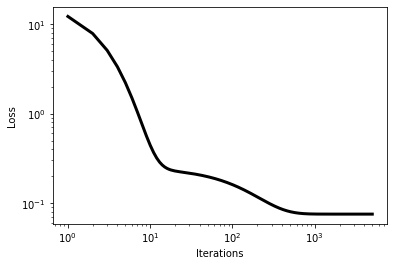

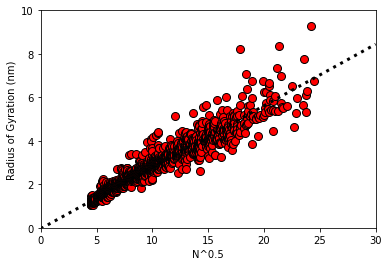

r2 = 0.941, MSE =  0.07503, MAE = 0.152


In [11]:
th0     = np.array([[-1.],[.75]])
nIters = 5000
thetaGD, EGD = Grad_Descent(X,y,th0,8e-6,nIters)
print("theta_0 = {:>8.4f}".format(thetaGD[0,0]))
print("theta_1 = {:>8.4f}".format(thetaGD[1,0]))

fig,ax = plt.subplots()
ax.plot(np.array(range(nIters+1))+1,np.array(EGD),linestyle='-',color = 'k',linewidth=3)
plt.xscale("log")
plt.yscale("log")
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
plt.show()

# examine solution
ax = plot_raw_data(X,y)
ax.plot(xline,f(xline,thetaGD),color='k',linewidth=3,linestyle=':')
plt.show()
r2    = r2_score(y,yhat)
mse  = mean_squared_error(y,yhat)
mae   = mean_absolute_error(y,yhat)
print("r2 = {:>5.3f}, MSE = {:>8.5f}, MAE = {:>5.3f}"\
      .format(r2,rmse,mae))

# Check against linear algebra
If run for enough iterations, the solution obtained from gradient descent should outperform our human-intuited estimated model, even if just slightly. Because this is least-squares linear regression, we can also compare our solution with that obtained via linear algebra. 



In [10]:
N = len(y)
M = 2
A = np.ones((N,M))
A[:,1] = X[:]
thetaOpt = np.linalg.inv(A.T@A)@A.T@y
#thetOpt  = np.linalg.pinv(A)@y
yhat  = f(X,thetaOpt)
r2    = r2_score(y,yhat)
mse   = mean_squared_error(y,yhat)
mae   = mean_absolute_error(y,yhat)
print("theta_0 = {:>8.4f}".format(thetaOpt[0]))
print("theta_1 = {:>8.4f}".format(thetaOpt[1]))
print("r2 = {:>5.3f}, MSE = {:>8.5f}, MAE = {:>5.3f}"\
      .format(r2,rmse,mae))

theta_0 =  -0.0384
theta_1 =   0.2827
r2 = 0.941, MSE =  0.07503, MAE = 0.152


# Incorporating train/test splits
In our example so far, we did something, which is not generally good practice in machine learning: the data we used to train/optimize the model was the same data that we ultimately tested on. Because of the simplicity of the model that we have here, we are not at significant risk of overfitting, but it is better if we can assess the model using data that was held-out or unseen during training.

In the following cells, we will demonstrate the use of some convenient functions from scikit-learn that allow us to create a simple train/test split of our data.

theta_0 =  -0.0787
theta_1 =   0.2878


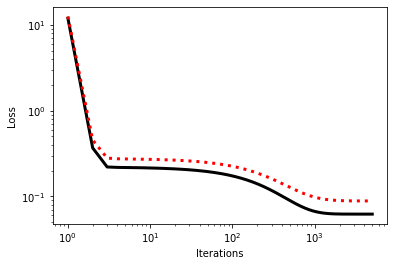

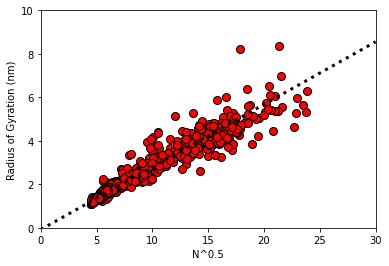

r2 = 0.930, MSE =  0.08859, MAE = 0.158


In [14]:
# create train vs. test split (here it is a 50/50 split)
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size = 0.5, shuffle = True,random_state=0)

thetaGD, E_tr, E_te = Grad_Descent(X_tr,y_tr,th0,8e-6,nIters,X_te,y_te)
print("theta_0 = {:>8.4f}".format(thetaGD[0,0]))
print("theta_1 = {:>8.4f}".format(thetaGD[1,0]))

fig,ax = plt.subplots()
ax.plot(np.array(range(nIters+1))+1,np.array(E_tr),linestyle='-',color = 'k',linewidth=3)
ax.plot(np.array(range(nIters+1))+1,np.array(E_te),linestyle=':',color = 'r',linewidth=3)
plt.xscale("log")
plt.yscale("log")
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
plt.show()

# examine solution
ax = plot_raw_data(X_te,y_te)
ax.plot(xline,f(xline,thetaGD),color='k',linewidth=3,linestyle=':')
plt.show()
yhat = f(X_te,thetaGD)
r2    = r2_score(y_te,yhat)
mse  = mean_squared_error(y_te,yhat)
mae   = mean_absolute_error(y_te,yhat)
print("r2 = {:>5.3f}, MSE = {:>8.5f}, MAE = {:>5.3f}"\
      .format(r2,rmse,mae))

# Cross-validation
An important consideration is how the choices that we make when constructing a model *impact* the model. Some of these choice may include things like hyperparameters associated with training (e.g., the number of training iterations and learning rate) or the actual constitution of our training data. If possible, we would like to mitigate any biases or deficiencies that we introduce in this fashion. Cross-validation provides one framework that can facililitate robustness with respect to the model training and our reporting of its results.  

In the next cells, we will perform $k$-fold cross-validation to provide a better estimate of prospective model performance. 

In [ ]:
# We will estimate the model accuracy using cross-validation
k     = 10
kf    = KFold(n_splits=k,shuffle=True,random_state=1)
r2s   = np.zeros([k])
mses  = np.zeros([k])
maes  = np.zeros([k])

for i,(iTrain,iTest) in enumerate(kf.split(y)):
    Xi_tr = X[iTrain]
    Xi_te = X[iTest]
    yi_tr = y[iTrain]
    yi_te = y[iTest]
    thetaGD, = Grad_Descent(X_tr,y_tr,th0,8e-6,nIters)
    yhat = f(X_te,thetaGD)
    (r2s[i],mses[i],maes[i]) = \
    (r2_score(y_te,yhat),mean_squared_error(y_te,yhat),mean_absolute_error(y_te,yhat))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import sklearn.manifold, sklearn.cluster
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole

np.random.seed(0)
import warnings

# Activity 1: Chemical Data Basics
In this activity, we will be working with a dataset on the aqueous solubility  of various molecules. Our main objective will be to construct and assess the performance of simple linear model for predicting solubility. Although linear modeling is not canonically machine learning, all the concepts and approaches we consider for treating/examining the data as well as evaluating the models will be transferable to building models based on deep learning algorithms.

Execute the following cell to import necessary modules and load the dataset. The data will be loaded into a Pandas dataframe named `soldata`. After, you can progress through the tasks as described.

In [ ]:
IPythonConsole.ipython_useSVG = True
warnings.filterwarnings("ignore")
sns.set_context("notebook")
sns.set_style(
    "dark",
    {
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.color": "#666666",
        "ytick.color": "#666666",
        "axes.edgecolor": "#666666",
        "axes.linewidth": 0.8,
    },
)
color_cycle = ["#1BBC9B", "#F06060", "#5C4B51", "#F3B562", "#6e5687"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color_cycle)

# Load the data from dmol-book
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
soldata.head()

# Dataset Exploration
One of the first things you should do for any ML task is simply get a feel for the data. As an end goal, we know we want to ***predict solubility***. Thus, ***solubility*** is our ***label*** for a regression task, and we will try model this as a function of molecular descriptors of a molecule; these are used to construct prospective ***input feature vectors*** that represent the molecule.

## Summary of Tasks
A. Take a moment to familiarize yourself with the modules that are imported in the previous cell. Then, look at the organization of the DataFrame, the first lines of which are shown above.

B. Plot the distribution of solubility values. Is there anything notable about its shape or range?

C. Examine pair correlations amongst possible input features. Are any descriptors highly correlated? How do the scale of the features compare?

# Task B
Plot the distribution of solubility values. Is there anything notable about its shape or range?

Useful function: Useful function: sns.distplot
https://seaborn.pydata.org/generated/seaborn.distplot.html

In [ ]:
sns.distplot(soldata.Solubility)
plt.show()


# Task C
Examine pair correlations amongst possible input features. Are any descriptors highly correlated? How do the scale of the features compare? What about correlation with the ***Solubility***?

Useful function: sns.pairplot
https://seaborn.pydata.org/generated/seaborn.pairplot.html

Note that if you run pairplot over all features, it may take awhile to run. You may wish to only examine a subset for this reason. 

In [ ]:
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]

# code for pair correlations
subset = [n for n in feature_names if np.random.random()<0.333]
sns.pairplot(soldata[subset])
plt.show()


In [ ]:
# code for looking at pair correlations with Solubility
num_cols = 3
num_rows = int( np.ceil(len(feature_names)/ num_cols))
fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,sharey=True,figsize=(12,12))
axs = axs.flatten()
for i,n in enumerate(feature_names):
  ax = axs[i]
  ax.scatter(soldata[n], soldata.Solubility, s=6, alpha=0.4)
  if i % num_cols == 0:
    ax.set_ylabel("Solubility")
  ax.set_xlabel(n)
  plt.tight_layout()
plt.show() 

# Feature scaling
Based on the disparate magnitudes of the possible features, we will perform a transformation of the input features to ensure everything has a similar "scale."

We will use standard scaling here. Although I will not represent that this is the *best* choice for scaling, it is simple/safe to implement. 

There are many scaling/transforming techniques available in packages like scikit-learn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing


# Task D: 
Determine and evaluate the performance of a linear model. You can compare your results with that of the "exact" least-squares result afforded by linear algebra. 


In [ ]:
# extract data set
y = np.array(soldata.Solubility[:])
X = np.array(soldata[feature_names])
N = len(y)
M = X.shape[1] + 1
A = np.ones((N,M))
A[:,1:] = X[:,:]
#thetaOpt = np.linalg.inv(A.T@A)@A.T@y 
thetaOpt = np.linalg.pinv(A)@y
yhat    = A@thetaOpt
fig, ax = plt.subplots()
ax.plot(y,yhat,marker='o',linestyle="",markersize=8,color='r',markeredgecolor='k', alpha = 0.5)
ax.set_aspect('equal', adjustable='box')
plt.xlim(-15,5)
plt.ylim(-15,5)
plt.show()

(7985, 17)
[ 0.66266243  0.55167596  0.74573751  0.44560363 -0.98735297 -0.74262644
 -0.67197808  2.24165037  0.71608151 -0.81102151 -0.32709912 -0.42073195
 -0.91195572 -0.97723182  0.63327093 -2.19088662 -0.46601569]
(7985, 17)
[ 0.67168308  0.56271087  0.75288851  0.44978121 -0.98606928 -0.74020689
 -0.67731497  2.2979138   0.72762402 -0.80613049 -0.32532152 -0.41927133
 -0.91242233 -0.97115044  0.63565738 -2.19823093 -0.46472986]
(7986, 17)
[ 0.66481244  0.55026935  0.74235275  0.44217854 -0.99052426 -0.75837199
 -0.66882815  2.18469492  0.71264779 -0.81875172 -0.36006801 -0.4485811
 -0.94373905 -0.98302111  0.62527498 -2.16908788 -0.46341353]
(7986, 17)
[ 0.71987912  0.58287619  0.81193542  0.48708865 -1.01039072 -0.73517037
 -0.67607478  2.39545265  0.77913454 -0.83946299 -0.32326677 -0.41611253
 -0.93224841 -1.00143824  0.6789977  -2.1943064  -0.49503146]
(7986, 17)
[-0.52301996  0.11859671 -0.31357522 -0.35063347 -0.71762429 -0.06614572
 -0.68165734 -0.73200014 -0.49373177  0.7

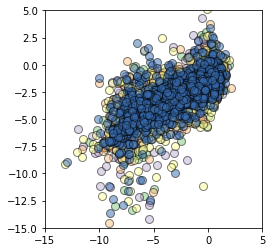

In [20]:
from sklearn.model_selection  import train_test_split, KFold
from sklearn.linear_model     import LinearRegression, Lasso, Ridge
from sklearn.metrics          import r2_score
from sklearn.preprocessing    import StandardScaler

# We will estimate the model accuracy using cross-validation
k  = 5
kf = KFold(n_splits=k,shuffle=True,random_state=None)
r2 = np.zeros([k])
fig, ax = plt.subplots()
colors =  plt.cm.Accent([i for i in range(k)])
for i,(iTrain,iTest) in enumerate(kf.split(y)):
    Xi_tr = X[iTrain]
    Xi_te = X[iTest]
    yi_tr = y[iTrain]
    yi_te = y[iTest]

    # feature scaling (here using standard scaling)
    scaler = StandardScaler()
    print(Xi_tr.shape)
    scaler.fit(Xi_tr)
    Xi_tr_sc = scaler.transform(Xi_tr)
    print(Xi_tr_sc[0])
    # linear regression
    model  = LinearRegression().fit(Xi_tr_sc, yi_tr)
    yihat_te = model.predict(scaler.transform(Xi_te))
    r2[i] = r2_score(yi_te,yihat_te)
    ax.plot(yi_te,yihat_te,marker='o',linestyle="",markersize=8,color=colors[i],markeredgecolor='k', alpha = 0.5)
ax.set_aspect('equal', adjustable='box')
print(np.mean(r2))
print(r2)

plt.xlim(-15,5)
plt.ylim(-15,5)
plt.show()

# Impact of regularization
In the previous cells, we considered a model using all possible features, but earlier inspection of the data suggests that some of the features are highly correlated. The implication is that we might obtain a *simpler* model without any significant loss in accuracy were we to use a different set of features.

As a first pass towards something akin to feature selection, we will examine the impact of regularization on the model parameters. We discussed L1 and L2 regularization. Use the cells below to examine how using these regularization terms impacts the model parameters (i.e., coefficients).

For simplicity, we will just use a simple train/test split. Examine the performance on the test set for the different methods and how this and the produced coefficients are impacted by the regularization weighting.

In [ ]:
# set weight for regularization term
my_alpha = 0.2

# create train vs. test split
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size = 0.8, random_state = 1)

# feature scaling (here using standard scaling)
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_sc = scaler.transform(X_tr)

# create and test model with simple linear regression
model_L0  = LinearRegression().fit(X_tr_sc, y_tr)
yhat_L0   = model_L0.predict(scaler.transform(X_te))
r2_L0     = r2_score(y_te,yhat_L0)

# create and test model with L1 regularization
model_L1  = Lasso(alpha=my_alpha).fit(X_tr_sc, y_tr)
yhat_L1   = model_L1.predict(scaler.transform(X_te))
r2_L1     = r2_score(y_te,yhat_L1)

# create and test model with L2 regularization
model_L2  = Ridge(alpha=my_alpha).fit(X_tr_sc, y_tr)
yhat_L2   = model_L2.predict(scaler.transform(X_te))
r2_L2     = r2_score(y_te,yhat_L2)

# plot and compare coefficients
fig, ax = plt.subplots()
colors =  plt.cm.Accent([i for i in range(3)])
h      = [0 for i in range(3)]
h[0], = ax.plot(range(M-1),model_L0.coef_,marker='o',linestyle="--",markersize=8,color=colors[0],markeredgecolor='k',label='L0')
h[1], = ax.plot(range(M-1),model_L1.coef_,marker='^',linestyle="--",markersize=8,color=colors[1],markeredgecolor='k',label='L1')
h[2], = ax.plot(range(M-1),model_L2.coef_,marker='s',linestyle="--",markersize=8,color=colors[2],markeredgecolor='k',label='L2')
plt.xticks(range(M-1),feature_names,rotation=90)
ax.legend(handles=h)
plt.show()

print("Coefficients of determination are..")
print("L0: {:>8.3f}, L1: {:>8.3f}, L2: {:>8.3f}".format(r2_L0,r2_L1,r2_L2))

# Feature Selection
From previous results and analysis, we can probably conclude that we do not need all of the features for an accurate model. We mentioned a variety of feature selection methods. Here, we'll use a simple greedy correlation filter to remove "redundant" features. 


In [ ]:
# 
rmax        = 0.8
subset      = [n for n in feature_names]
while True:
  absr = np.abs(soldata[subset].corr(method='pearson').to_numpy())
  np.fill_diagonal(absr,0.)
  imax = np.argmax(absr)
  jmax = imax%len(subset)
  imax = int(imax/len(subset))
  if absr[imax,jmax] < rmax:
    break
  rem_n = subset.pop(jmax)
  print("Removing feature {} with correlation of {:>5.3f} with {}".format(rem_n,absr[imax,jmax],subset[imax]))

Xsub = np.array(soldata[subset])

# create train vs. test split
Xsub_tr, Xsub_te, y_tr, y_te = train_test_split(Xsub,y,test_size = 0.8, random_state = 1)

# feature scaling (here using standard scaling)
scaler = StandardScaler()
scaler.fit(Xsub_tr)
Xsub_tr_sc = scaler.transform(Xsub_tr)

# create and test model with simple linear regression
model_L0  = LinearRegression().fit(Xsub_tr_sc, y_tr)
yhat_L0   = model_L0.predict(scaler.transform(Xsub_te))
r2_L0     = r2_score(y_te,yhat_L0)
print(r2_L0)

# Activity 2: Fun with Neural Networks

In this activity session, we are going to use the Keras API to build simple, feed-forward deep neural networks. At the end, you will have some freedom to use the API to investigate the impact of hyperparameters and model complexity with the same solubility dataset.


In [16]:
import numpy  as np
import pandas as pd
import tensorflow as tf
from tensorflow       import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import sklearn.metrics as sklm
import pydot
import graphviz

# How to build Sequential models (simple example)
We will start with the "sequential" model, which is really easy to use! You can play around with the different parameters and check the output with the .summary() method. **Can you make sense of the number of parameters that are reported???**

In [17]:
# Create Model Container
model = keras.Sequential(name="myFirstModel")

# Define Layers
inputLayer= keras.Input(shape=(4,))
layer1= layers.Dense(10,activation='relu',name="myFirstLayer")
layer2= layers.Dense(8,activation='tanh',name="oldNewsLayer")
output= layers.Dense(1,activation=None,name="outputLayer")

# Add layers to model
model.add(inputLayer)
model.add(layer1)
model.add(layer2)
model.add(output)

# Admire Model
model.summary()

Model: "myFirstModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 myFirstLayer (Dense)        (None, 10)                50        
                                                                 
 oldNewsLayer (Dense)        (None, 8)                 88        
                                                                 
 outputLayer (Dense)         (None, 1)                 9         
                                                                 
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


# How to build models with Functional API (simple example)
We will also demonstrate the functional API. The functional API is more flexible than the Sequential API and permits you more control over the architecture. By contrast, `Sequential` models can only be fully connected, feed forward. 

Model: "mySecondModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 myFirstLayer (Dense)        (None, 10)                50        
                                                                 
 oldNewsLayer (Dense)        (None, 8)                 88        
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


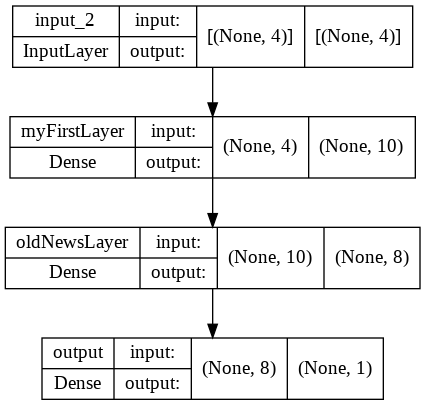

In [18]:
# Define Layers
inputLayer = keras.Input(shape=(4,))
layer1= layers.Dense(10,activation='relu',name="myFirstLayer")
layer2= layers.Dense(8,activation='tanh',name="oldNewsLayer")
output= layers.Dense(1,activation=None,name="output")

# Connect layers using "layer calls"
# we want to achieve
# inputLayer --> layer1 --> layer2 --> outputs
x = layer1(inputLayer)
x = layer2(x)
outputs = output(x)

# Build model from inputs/outputs
model = keras.Model(inputs=inputLayer,outputs=outputs,\
        name="mySecondModel")

# Admire Model
model.summary()
keras.utils.plot_model(model,"model.png",show_shapes=True)

# Return of the Solubility Dataset
So, now we are going to try and apply what we have learned to create a neural network that can predict solubility from chemical descriptors of a molecule.  

In [21]:
# Load and extract the data from dmol-book
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]
y = np.array(soldata.Solubility[:]).reshape([-1,1]) 
X = np.array(soldata[feature_names])
# note the reshape on y above, which forces the structure to a matrix/2d array
# this is the form that will be expected by Keras
# the first index to an array corresponds to a specific example
# the size of the second index is the dimensionality
print(X.shape,y.shape)

(9982, 17) (9982, 1)


# Data Preprocessing

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                576       
                                                                 
 dense_10 (Dense)            (None, 5)                 165       
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 747
Trainable params: 747
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
250/250 [==============================] - 2s 5ms/step - loss: 0.6153 - mean_absolute_error: 0.5834 - val_loss: 0.2924 - val_mean_absolute_error: 0.4200
Epoch 2/500
250/250 [==============================] - 1s 4ms/step - loss: 0.4346 - mean_absolute_error: 0.4787 - val_loss: 0.2537 - val_mean_absolute_erro

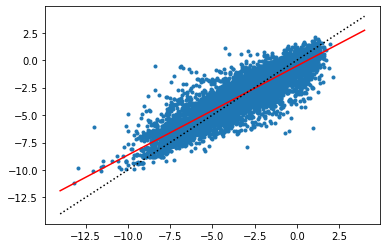

In [27]:
inScaler = StandardScaler() # scaler for features
outScaler= StandardScaler() # scaler for labels
inScaler.fit(X)
outScaler.fit(y)
Xsc = inScaler.transform(X)  # these are the scaled features
ysc = outScaler.transform(y) # these are the scaled labels

model  = keras.Sequential() # this initializes our simple model, but it doesn't have anhything in it!
hidden1= layers.Dense(32,activation="relu") # here we create 20-neuron layer with relu activation
hidden2= layers.Dense(5,activation="relu")  # this is a 5-neuron layer, again with relu
out    = layers.Dense(1)    # we will only have one output, activation=None means linear/identity
model.add(hidden1)
model.add(hidden2)
model.add(out)
model.build((None,Xsc.shape[1])) # this last line specifies the input shape; there are lots of ways to do this
model.summary()
keras.utils.plot_model(model,"model.png",show_shapes=True)

# now we compile the model and train it
model.compile(optimizer="SGD",loss="mean_squared_error",metrics=["mean_absolute_error"])
hist = model.fit(x=Xsc,y=ysc,epochs=500,validation_split=0.2)

ypredsc = model.predict(Xsc) 
ypred   = outScaler.inverse_transform(ypredsc)
plt.plot(y,ypred,".")
linearFit = LinearRegression().fit(y,ypred)
r2 = sklm.r2_score(y,ypred)
mae= sklm.mean_absolute_error(y,ypred)
mse=sklm.mean_squared_error(y,ypred)
print("r2 = {:>5.2f}, mae = {:>5.2f}, mse = {:>5.2f}".format(r2,mae,mse))
xline = np.array([[-14],[4]])
yline = linearFit.predict(xline)
plt.plot(xline,yline,'-r')
plt.plot(xline,xline,':k')

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


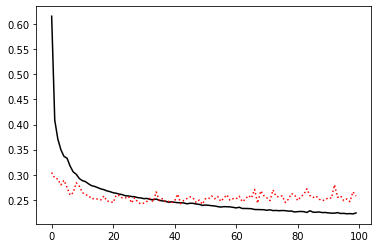

In [26]:
print(hist.history.keys())
loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(loss,'-k')
plt.plot(val_loss,':r')